In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from transformer.embed import PatchEmbed
from transformer.utils import random_mask, remove_masked_patches, add_masked_patches, unpatchify
def load_image(image_path):
    """
    Loads an image and converts it to a PyTorch tensor.
    Args:
    image_path (str): Path to the image file.
    Returns:
    torch.Tensor: Image tensor of shape (C, H, W).
    """
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resize for consistency
    transforms.ToTensor(),
    ])
    image_tensor = transform(image) # Shape: (C, H, W)
    return image_tensor

In [8]:
def visualize_tensor(tensor, title="Tensor Visualization"):
    """
    Visualizes a tensor as an image.
    
    Args:
    tensor (torch.Tensor): Tensor of shape (C, H, W) or (H, W).
    title (str): Title of the plot.
    """
    if tensor.dim() == 3 and tensor.size(0) == 3:
        # Convert tensor to numpy array and transpose to (H, W, C)
        np_img = tensor.permute(1, 2, 0).cpu().numpy()
    elif tensor.dim() == 2:
        # Convert tensor to numpy array
        np_img = tensor.cpu().numpy()
    else:
        raise ValueError("Unsupported tensor shape for visualization")
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np_img, cmap='gray' if tensor.dim() == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [9]:
def patchify(x, patch_size):
    """
    Extracts patches from videos and flattens them without using F.unfold.

    Args:
        x (torch.Tensor): Tensor of shape (bs, depth, in_channels, height, width)
        patch_size (tuple of int): Size of each patch as (D, H, W).

    Returns:
        torch.Tensor: Patches of shape (bs, num_patches, D * H * W * in_channels)
    """
    bs, depth, in_channels, height, width = x.shape
    D, H, W = patch_size

    assert depth % D == 0 and height % H == 0 and width % W == 0, "Dimensions must be divisible by patch size."

    # Calculate the number of patches along each dimension
    num_patches_d = depth // D
    num_patches_h = height // H
    num_patches_w = width // W

    # Permute x to (bs, depth, height, width, in_channels)
    x = x.permute(0, 1, 3, 4, 2).contiguous()

    # Reshape x to (bs, num_patches_d, D, num_patches_h, H, num_patches_w, W, in_channels)
    x = x.view(bs, num_patches_d, D, num_patches_h, H, num_patches_w, W, in_channels)

    # Permute x to (bs, num_patches_d, num_patches_h, num_patches_w, D, H, W, in_channels)
    x = x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous()

    # Combine the patches and flatten
    num_patches = num_patches_d * num_patches_h * num_patches_w
    patch_dim = D * H * W * in_channels
    patches = x.view(bs, num_patches, patch_dim)

    return patches

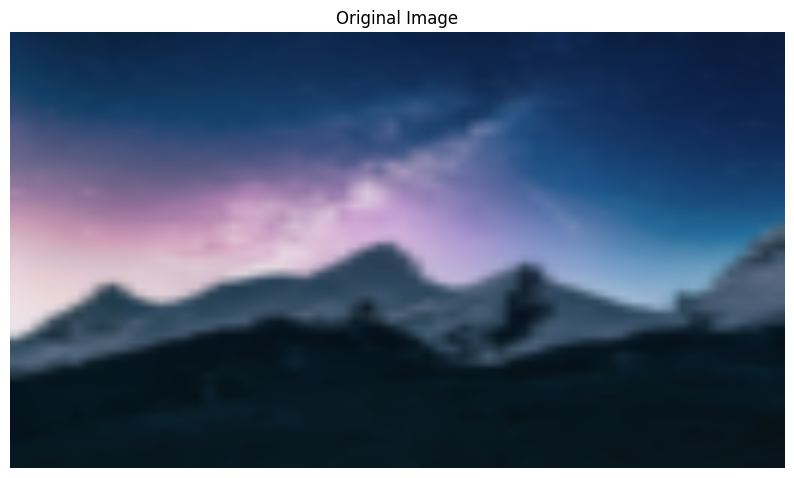

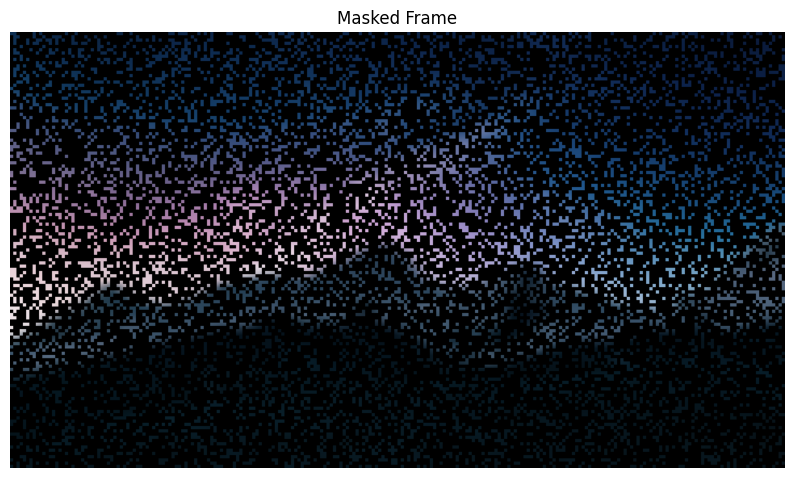

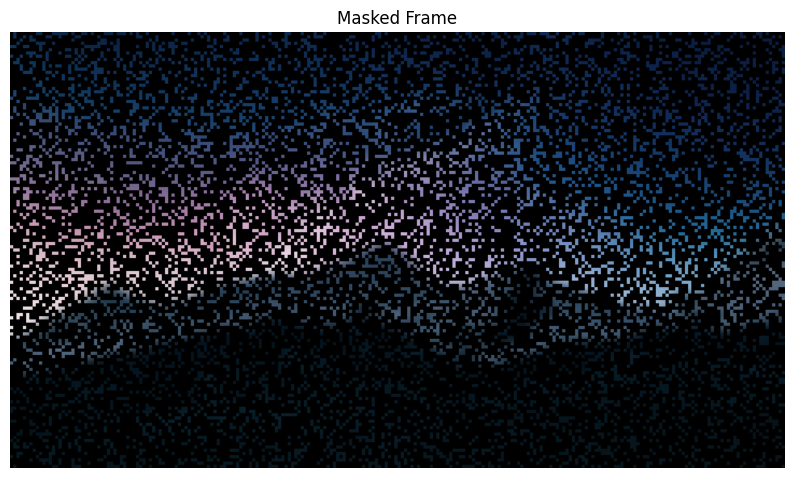

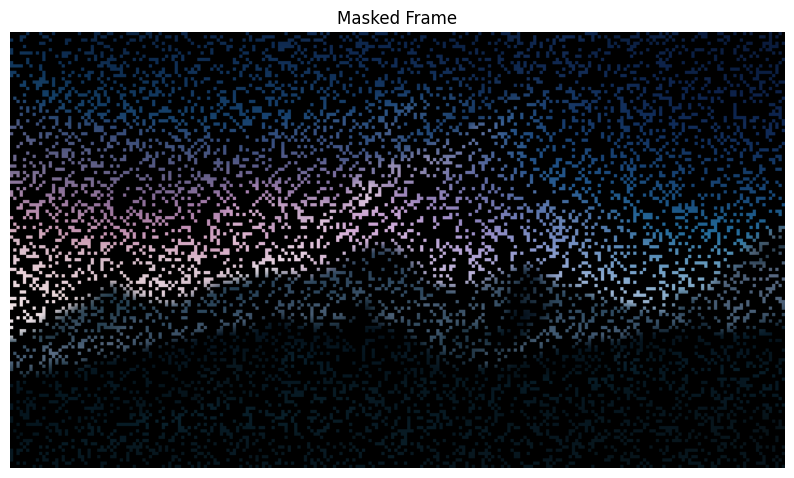

In [10]:
# Load the image
image_path = 'image.png'
image_tensor = load_image(image_path)
transform = transforms.Resize((1080, 1920))
image_tensor = transform(image_tensor)

# Simulate a video by repeating the same image 3 times
video_tensor = image_tensor.unsqueeze(0).repeat(3, 1, 1, 1).unsqueeze(0)  # Shape: (1, 3, C, H, W)

# Define parameters
bs = 1
depth = 3
height, width = 1080, 1920
patch_size = (1, 8, 8)
mask_ratio = 0.75

# Generate a random mask
mask = random_mask(bs, depth, height, width, patch_size, mask_ratio)
# Apply the mask to the video tensor

# Instead of using an embedding, we will put the patches' pixels as the embeddings placeholder, so that we can easily convert it back to the image
# Convert video_tensor from (bs, D, C, H, W) to (bs, num_patches, patch_pixels)
bs, D, C, H, W = video_tensor.shape
patch_D, patch_H, patch_W = patch_size
num_patches_d = D // patch_D
num_patches_h = H // patch_H
num_patches_w = W // patch_W
num_patches = num_patches_d * num_patches_h * num_patches_w

# Reshape and permute to get patches
video_patches = patchify(video_tensor, patch_size)

masked_patches = remove_masked_patches(video_patches, mask)
patches = add_masked_patches(masked_patches, mask)

visualize_tensor(image_tensor, 'Original Image')

masked_frames = unpatchify(patches, patch_size, depth, height, width)[0, :, :, :, :]
# Visualize the masked video frames
for i in range(depth):
    masked_frame = masked_frames[i, :, :, :]
    visualize_tensor(masked_frame, 'Masked Frame')
    plt.show()

